[Jump to All in One](#All-in-One)


In [46]:
import scipy.stats as sstats
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wid

In [47]:
plt.rcParams['font.size'] = 18

In [48]:
def define_model(num_observations):
    return np.ones(num_observations).reshape(-1,1)

# Problem Setup 

- We have a one-dimensional input space $\Lambda \subset \mathcal{R}$ 
    - we choose some nominal value $\lambda_0$ to represent a true parameter that we attempt to identify
    - we map this value to the output space and perturb it with noise from a mean-zero gaussian distribution with
    - we use an initial distribution that is gaussian
    - we propagate $N$ samples from this disribution, so the output matrix has each sample in a column. 
    
- Let $M$ denote the number of observations made of an experiment (number of trials/repetitions)
    - these are rows in our output matrix.
    
- We define our map $A: \mathcal{R} \to \mathcal{R}^M$ to repeat the values and represent multiple trials


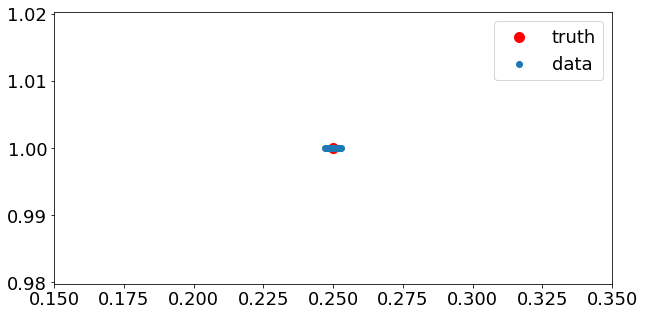

In [49]:
# INPUT SPACE PARAMETERS
np.random.seed(1)
prior_mean = 0.0
prior_std = 0.25
lam_true = 0.25
lambda_true = np.array([[lam_true]])
N = 10000 # number of iid MC input samples used to solve inverse problem 

# OUTPUT SPACE PARAMETERS
data_std = 0.00125
M = 50 # number of observations
A = define_model(M)
true_data = A@lambda_true
observed_data = true_data + data_std*np.random.randn(M).reshape(-1,1)
initial_dist = sstats.distributions.norm(loc=prior_mean, scale=prior_std)
# initial_dist = sstats.distributions.uniform(loc=0, scale=0.5)


plt.figure(figsize=(10,5))
plt.scatter(true_data[0],[1], c='r', s=100, label='truth')
plt.scatter(observed_data,np.ones(M), label='data')
plt.legend()
plt.xlim(0.15, 0.35)

# PLOTTING PARAMETERS
ns = 100


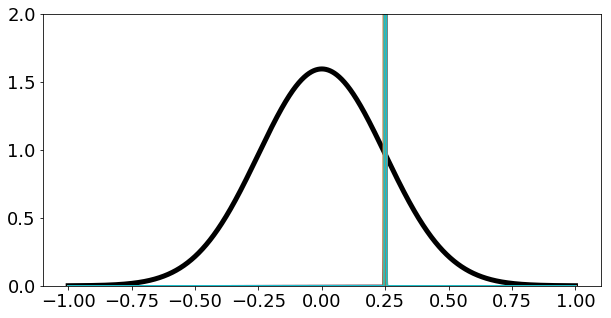

In [50]:
initial_eval = np.linspace(-1, 1, 5000)
plt.figure(figsize=(10,5))
plt.plot(initial_eval, initial_dist.pdf(initial_eval),c='k',lw=5)
for i in range(M):
    sample = observed_data[i]
    temp_dist = sstats.distributions.norm(loc=sample, scale=data_std)
    plt.plot(initial_eval, temp_dist.pdf(initial_eval))
# plt.xlim(0.15, 0.3)
plt.ylim(0,2)
plt.show()

# Generate Input and Output Samples

In [51]:
# generate input samples and map them to data space
input_samples = initial_dist.rvs(N).reshape(1,-1)
print('input sample shape:', input_samples.shape)

input sample shape: (1, 10000)


In [52]:
# define map and output space
output_samples = A@input_samples
print('output sample shape:', output_samples.shape)

output sample shape: (50, 10000)


In [53]:
def mse_fun(output_samples):
    return (1./M)*np.sum( np.power(np.divide(output_samples - observed_data, data_std), 2), axis=0)
mse = mse_fun(output_samples)
print('MSE computed. shape:', mse.shape)

MSE computed. shape: (10000,)


In [54]:
print('MSE min:', mse.min(), 'MSE max:', mse.max())

MSE min: 0.944451319549 MSE max: 867250.793328


## Characterize Data Space

- you have to choose some way to characterize the push forward of the initial distribution.
- use some sort of parametric fit or kernel density estimation

In [55]:
a, l, s = sstats.distributions.gamma.fit(mse)
print(a, l, s)
gamma_fit = sstats.distributions.gamma(a=a,loc=l,scale=s)

d, l, s = sstats.distributions.chi2.fit(mse)
chi2_fit = sstats.distributions.chi2(df=d,loc=l,scale=s)

gkde_fit = sstats.gaussian_kde(mse,0.0125)

0.580575084562 0.944451319549 120605.604316


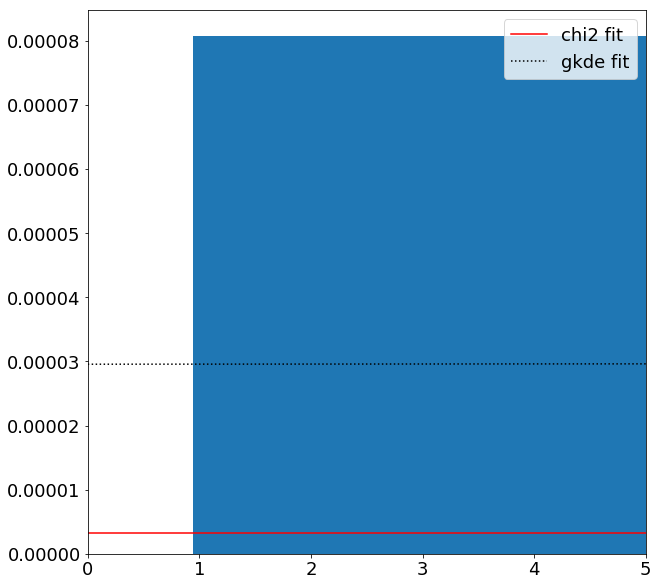

In [56]:
x_eval = np.linspace(0,10,500)
gamma_eval = gamma_fit.pdf(x_eval)
chi2_eval = chi2_fit.pdf(x_eval)
gkde_eval = gkde_fit.evaluate(x_eval)

num_bins = 1000
plt.figure(figsize=(10,10))
plt.hist(mse, num_bins, density=True)
# plt.plot(x_eval, gamma_eval, c='b', label='gamma fit')
plt.plot(x_eval, chi2_eval, c='r', label='chi2 fit')
plt.plot(x_eval, gkde_eval, ':',c='k', label='gkde fit')
plt.xlim(0,5)
# plt.ylim(0,4)
plt.legend()
plt.show()

## Choose which approximation method you will use

In [57]:
def pf_initial_dist_PDF(x):
#     return chi2_fit.pdf(x)
#     return gamma_fit.pdf(x)
    return gkde_fit.evaluate(x)


## Compute pushforward of initial distribution

In [58]:
eval_pf_initial = pf_initial_dist_PDF(mse)
print('Pushforward of Initial Distribution computed. shape:', eval_pf_initial.shape)

Pushforward of Initial Distribution computed. shape: (10000,)


# Define observed density

In [59]:
obs_dist = sstats.distributions.gamma(a=M/2.0, scale=2.0/M)
# obs_dist = sstats.distributions.chi2(df=M)
eval_obs = obs_dist.pdf(mse)


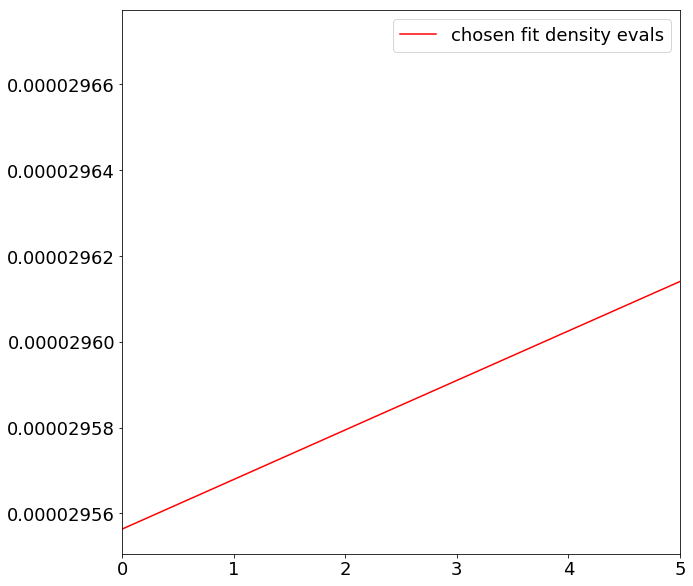

In [60]:
plt.figure(figsize=(10,10))
# num_bins = 2000
# plt.hist(mse, num_bins, density=True)
plt.plot(x_eval, pf_initial_dist_PDF(x_eval), c='r', label='chosen fit density evals')
# plt.plot(x_eval, obs_dist.pdf(x_eval), c='k', label = 'observed')
plt.legend()
plt.xlim(0,5)
# plt.ylim(0,0.5)
plt.show()

In [61]:
eval_initial = initial_dist.pdf(input_samples)
ratio = np.divide(eval_obs, eval_pf_initial)
updated_dist = eval_initial*ratio

print('Ratio computed. Mean:', np.mean(ratio))

Ratio computed. Mean: 99.4113995006


In [62]:
def eval_updated(x):
    y = mse_fun(A@x.reshape(1,-1))
    return  initial_dist.pdf(x)*(obs_dist.pdf(y)/pf_initial_dist_PDF(y))

# Interrogate Updated Density

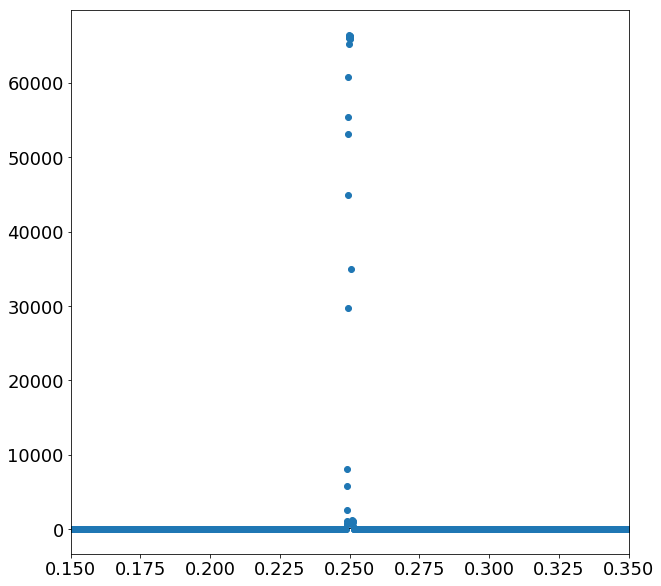

In [63]:
plt.figure(figsize=(10,10))
plt.scatter(input_samples, updated_dist)
# plt.plot(initial_eval, eval_updated(initial_eval))
plt.vlines(0.25,0,200)
plt.xlim(0.15, 0.35)
plt.show()

## Perform Accept/Reject and Visualize Results

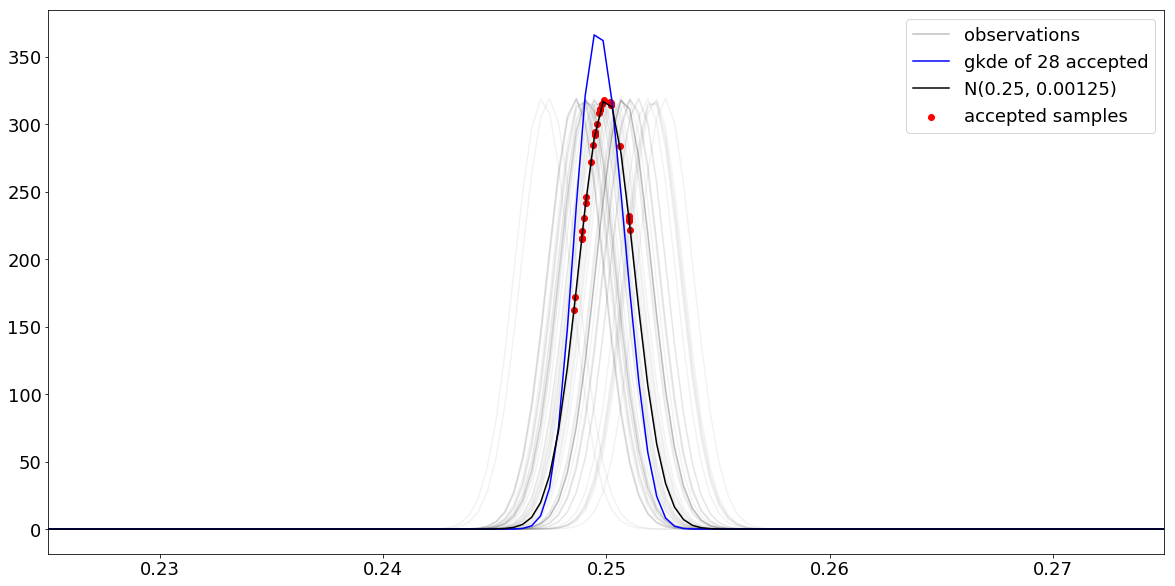

In [64]:
rn = np.random.rand(N)
accepted_inds = [i for i in range(N) if ratio[i] > rn[i]]
# plt.scatter(input_samples[0,accepted_inds], updated_dist[0,accepted_inds])
g = sstats.gaussian_kde(input_samples[0,accepted_inds], bw_method=1)
plt.figure(figsize=(20,10))
for i in range(M-1):
    sample = observed_data[i]
    temp_dist = sstats.distributions.norm(loc=sample, scale=data_std)
    plt.plot(initial_eval, temp_dist.pdf(initial_eval), c='k', alpha=0.05)
plt.plot(initial_eval, sstats.distributions.norm.pdf(loc=observed_data[M-1], scale=data_std, x=initial_eval), c='k', alpha=0.25, label='observations')

temp_dist = sstats.distributions.norm(loc=0.25, scale=data_std)
sample = input_samples[0,accepted_inds[0]]
plt.scatter(sample, temp_dist.pdf(sample), c='red', alpha=1, label='accepted samples')
for i in range(1,len(accepted_inds)):
    sample = input_samples[0,accepted_inds[i]]
    plt.scatter(sample, temp_dist.pdf(sample), c='red', alpha=1)

plt.plot(initial_eval, g.evaluate(initial_eval), label='gkde of %d accepted'%len(accepted_inds), c='b')

    
temp_dist = sstats.distributions.norm(loc=lam_true, scale=data_std)
plt.plot(initial_eval, temp_dist.pdf(initial_eval), label='N(%2.2f, %2.5f)'%(lam_true, data_std), c='k')
# plt.plot(initial_eval, g.evaluate(initial_eval), label='gkde of %d accepted'%len(accepted_inds), c='b')

plt.xlim(0.225,0.275)
plt.legend()
plt.show()

In [65]:
def makemodel(t):
    def model(lam = np.array([[0.5]]) ):
        QoI = lam[0,:].reshape(-1,1)*np.exp(-0.5*t)
        return QoI.T
    return model

def makemodel(t):
    num_obs = len(t)
    t = t.reshape(1,-1)
    def model(lam = None):
        if lam is None: 
            lam = np.zeros((1,3))
            lam[:,0] = initial_condition_0
            lam[:,1] = decay_rate_0
            lam[:,2] = frequency_0
        initial_condition = lam[:,0].reshape(-1,1)
        decay_rate = lam[:,1].reshape(-1,1)
        frequency = lam[:,2].reshape(-1,1)
        QoI = initial_condition*np.exp(-decay_rate*t)
        QoI *= np.cos(np.multiply(0.5*frequency*t, 2*np.pi))
        if QoI.shape[0] == 1:
            return QoI.reshape(1,-1) # this allows support for simpler 1D plotting.
        else:
            return QoI
    return model


# All in One

In [71]:
def solve_problem(N = 1000, 
                prior_mean = 0.0,
                prior_std = 0.25,
                M = 10, 
                data_std = 0.0125,
                lam_true = 0.5, 
                time = (1,5),
                seed=None,
                plot=True):
    start_time, end_time = time
    
    N, M, seed = int(N), int(M), int(seed) # enforce types 
    # INPUT SPACE PARAMETERS
    if seed is not None:
        np.random.seed(seed)
#     prior_mean = 0.0
#     prior_std = 0.25
#     lam_true = 0.25
    lambda_true = np.array([[lam_true]])
#     N = 1000 # number of iid MC input samples used to solve inverse problem 

    # OUTPUT SPACE PARAMETERS
#     data_std = 0.0125
#     M = 50 # number of observations
#     A = define_model(M)
    ####

    t = np.linspace(start_time, end_time, M)
    ed_model = makemodel(t)
    
    def model(input_samples):
#         output_samples = A@input_samples
        output_samples = ed_model(input_samples)
        return output_samples
    
    true_data = model(lambda_true)
    
    observed_data = true_data + data_std*np.random.randn(M).reshape(-1,1)
    obs_data_mean, obs_data_std = np.mean(observed_data), np.std(observed_data)
#     print('Stats on observed data:', 'mean:', obs_data_mean, 'sd:', obs_data_std)
    initial_dist = sstats.distributions.norm(loc=prior_mean, scale=prior_std)
    # initial_dist = sstats.distributions.uniform(loc=0, scale=0.5)


    # plt.figure(figsize=(10,5))
    # plt.scatter(true_data[0],[1], c='r', s=100, label='truth')
    # plt.scatter(observed_data,np.ones(M), label='data')
    # plt.legend()
    # plt.xlim(0.15, 0.35)

    # PLOTTING PARAMETERS
    num_bins = 100
    mesh_sz = 2500
    
    initial_eval = np.linspace(-1, 1, mesh_sz)
    updated_eval = np.linspace(0.2, 0.3, mesh_sz)
    
    if plot:
        fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,15))
        ### VISUALIZE INITIAL VS DATA OBSERVED

        axs[0,0].plot(initial_eval, initial_dist.pdf(initial_eval),c='k',lw=5)
        for i in range(M):
            sample = observed_data[i]
            temp_dist = sstats.distributions.norm(loc=sample, scale=data_std)
            axs[0,0].plot(initial_eval, temp_dist.pdf(initial_eval))
        # plt.xlim(0.15, 0.3)
        axs[0,0].set_ylim(0,2)
        axs[0,0].set_title("Initial Density and observed data with uncertainty")


    # generate input samples and map them to data space
    input_samples = initial_dist.rvs(N).reshape(1,-1)
    print('input sample shape:', input_samples.shape)

    # define map and output space
    output_samples = model(input_samples)
    print('output sample shape:', output_samples.shape)

    def loss_fun(output_samples):
#         return (1./M)*np.sum( np.power(np.divide(output_samples - observed_data, data_std), 2), axis=0)
#         return (1./np.sqrt(2*M))*np.sum( np.power(np.divide(output_samples - observed_data, data_std) , 2) - 1.0, axis=0)
        return (1./data_std)*(1./np.sqrt(M))*np.sum( output_samples - observed_data, axis=0)
    
    mse = loss_fun(output_samples)
#     print('Loss fun computed. shape:', mse.shape)
    print('Loss fun min:', mse.min(), 'MSE max:', mse.max())

#     x_eval = np.linspace(-1000,1000,mesh_sz*5)
    x_eval = np.linspace(mse.min(), mse.max(), mesh_sz*5)
    
    ### Define Observed and Pushforward of Initial
    # FIT PF
#     a, l, s = sstats.distributions.gamma.fit(mse)
#     # print(a, l, s)
#     gamma_fit = sstats.distributions.gamma(a=a,loc=l,scale=s)

#     d, l, s = sstats.distributions.chi2.fit(mse)
#     chi2_fit = sstats.distributions.chi2(df=d,loc=l,scale=s)

    gkde_fit = sstats.gaussian_kde(mse)


    def pf_initial_dist_PDF(x):
    #     return chi2_fit.pdf(x)
#         return gamma_fit.pdf(x)
        return gkde_fit.evaluate(x)

    eval_pf_initial = pf_initial_dist_PDF(mse)
    # print('Pushforward of Initial Distribution computed. shape:', eval_pf_initial.shape)

    obs_dist = sstats.distributions.norm()
#     obs_dist = sstats.distributions.gamma(a=M/2.0, scale=2.0/M)
    # obs_dist = sstats.distributions.chi2(df=M)
    eval_obs = obs_dist.pdf(mse)


#     gamma_eval = gamma_fit.pdf(x_eval)
#     chi2_eval = chi2_fit.pdf(x_eval)
    gkde_eval = gkde_fit.evaluate(x_eval)
    if plot:
        axs[0,1].hist(mse, num_bins, density=True)
    #     axs[0,1].plot(x_eval, gamma_eval, c='b', label='gamma fit')
    #     axs[0,1].plot(x_eval, chi2_eval, c='r', label='chi2 fit')
        axs[0,1].plot(x_eval, gkde_eval, '--',c='r', label='gkde fit')
        axs[0,1].plot(x_eval, obs_dist.pdf(x_eval), c='k', label = 'observed')
        axs[0,1].set_xlim(-5,5)
        axs[0,1].set_ylim(0,np.max(gkde_eval))
        axs[0,1].legend()



    ### SOLVE INVERSE PROBLEM 
    eval_initial = initial_dist.pdf(input_samples)
#     print('MIN oF PF_INPUT_EVAL:.', np.min(eval_pf_initial))

    ratio = np.divide(eval_obs, eval_pf_initial) # COMPUTE RATIO
    updated_dist = eval_initial*ratio # EVALUATE UPDATED DENSITY ON INPUT SAMPLES

#     print('Ratio computed. Mean:', np.mean(ratio))

    ### VISUALIZE RESULTS
    def eval_updated(x):
        y = loss_fun(model(x.reshape(1,-1)))
        return  initial_dist.pdf(x)*np.divide(obs_dist.pdf(y), pf_initial_dist_PDF(y))
    
    input_samples = input_samples.ravel() # reshape 1D vectors for easier access
    updated_dist = updated_dist.ravel()
    
    
    
    updated_evaluated_on_mesh = eval_updated(updated_eval) # VISUALIZE UPDATED DENSITY
    updated_eval_at_truth = eval_updated(np.array([lam_true]))
    
    max_input_sample_index = np.where(updated_dist == np.max(updated_dist))[0][0]
    rel_error_mc = np.abs( (input_samples[max_input_sample_index] - lam_true )/lam_true )
    
    max_eval_sample_index = np.where(updated_evaluated_on_mesh == np.max(updated_evaluated_on_mesh))[0][0]
    rel_error_mesh = np.abs( (updated_eval[max_eval_sample_index] - lam_true )/lam_true )
    
    if plot:
        axs[1,1].vlines(lam_true, 0, np.max(updated_evaluated_on_mesh), color='b', label='true value')
        axs[1,1].plot(updated_eval, updated_evaluated_on_mesh, c='k', label='updated eval, mesh: %d'%mesh_sz)
        axs[1,1].scatter(input_samples[max_input_sample_index], updated_dist[max_input_sample_index], c='b', s=250, label='Max (MC), RE:%1.2e'%rel_error_mc)
    #     axs[1,1].scatter(0.25, updated_eval_at_truth, s=25, label='density val @ truth: %2.4f'%updated_eval_at_truth)
        axs[1,1].scatter(updated_eval[max_eval_sample_index], updated_evaluated_on_mesh[max_eval_sample_index], c='orange', s=200, label='Max (mesh), RE:%1.2e'%rel_error_mesh)

    #     axs[1,1].set_xlim(0.15, 0.35)
        axs[1,1].set_xlim(0.2,0.3)
        # axs[1,1].set_ylim(0, 200)
        axs[1,1].set_title('Updated Density evaluated')
    

    # PLOT RESULTS AND OBSERVED DATA
    # np.random.seed(23)
    rn = np.random.rand(N)
    accepted_inds = [i for i in range(N) if ratio[i] > rn[i]]
    if plot:
        # axs[1,0].scatter(input_samples[0,accepted_inds], updated_dist[0,accepted_inds])
        if len(accepted_inds) > 1:
            g = sstats.gaussian_kde(input_samples[accepted_inds])
            axs[1,0].plot(initial_eval, g.evaluate(initial_eval), label='gkde of %d accepted'%len(accepted_inds), c='b', lw=2)

        for i in range(M-1):
            sample = observed_data[i]
            temp_dist = sstats.distributions.norm(loc=sample, scale=data_std)
            axs[1,0].plot(initial_eval, temp_dist.pdf(initial_eval), c='k', alpha=0.1)
        axs[1,0].plot(initial_eval, sstats.distributions.norm.pdf(loc=observed_data[M-1], scale=data_std, x=initial_eval), c='orange', alpha=0.75, label='observations') # OBSERVED DATA


        if len(accepted_inds) > 1:
            sample = input_samples[accepted_inds[0]]
            axs[1,0].scatter(sample, g.evaluate(sample), c='red', alpha=1, label='accepted samples')
            for i in range(1,len(accepted_inds)):
                sample = input_samples[accepted_inds[i]]
                axs[1,0].scatter(sample, g.evaluate(sample), c='red', alpha=1)
            axs[1,1].scatter(input_samples[accepted_inds], updated_dist[accepted_inds], c='red', s=50, label='accepted')
        axs[1,1].scatter(input_samples, updated_dist,  c='k', s=10, label='initial samples')    


        reference_dist = sstats.distributions.norm(loc=lam_true, scale=data_std)
        ref_dist_eval = reference_dist.pdf(initial_eval)
#         axs[1,0].plot(initial_eval, ref_dist_eval, label='N(%2.4f, %2.5f$^2$)'%(lam_true, data_std), c='green', lw=3, alpha=1.0)
        axs[1,0].vlines(lam_true, 0, np.max(ref_dist_eval))
        
        if M == -1: # can't compute std on sample size of 1, this makes no sense for timeseries
            approx_dist = sstats.distributions.norm(loc=obs_data_mean, scale=obs_data_std)
            axs[1,0].plot(initial_eval, approx_dist.pdf(initial_eval), label='N(%2.4f, %2.5f$^2$)'%(obs_data_mean, obs_data_std), c='purple', lw=3, alpha=1.0)
            # axs[1,0].plot(initial_eval, g.evaluate(initial_eval), label='gkde of %d accepted'%len(accepted_inds), c='b')

        axs[1,0].set_xlim(0.2,0.3)
    #     axs[1,0].set_xlim(0.15, 0.35)
        axs[1,0].set_title("Updated Density, observed data with uncertainty")
        axs[1,0].legend(fontsize=12)
        axs[1,1].legend(fontsize=12)
    if plot:
        plt.show()
        
    SUMMARY = {
        'N': N,
        'M': M, 
        'seed': seed, 
        'prior_mean': prior_mean,
        'prior_std': prior_std,
        'data_std': data_std,
        'lam_true': lam_true,
        'mud_val': input_samples[max_input_sample_index],
        'rel_error_mc': rel_error_mc,
        'obs_data_mean': obs_data_mean,
        'obs_data_std': obs_data_std,
        'num_accepted': len(accepted_inds),
        'time': [start_time, end_time],
        'mean_r': ratio.mean(),
        'mse_min': mse.min(),
        'mse_max': mse.max()
    }
    if not plot:
        return SUMMARY, input_samples[accepted_inds], observed_data

In [72]:
wid.interact_manual(solve_problem, 
                prior_mean=wid.FloatSlider(min=-0.25, max=0.25, step=0.05, continuous_update=False),  
                prior_std=wid.FloatSlider(value=0.25, min=0.125, max=0.5, step=0.125, readout_format='.2e', continuous_update=False),     
                data_std=wid.FloatSlider(value=0.01, min=0.0025, max=0.0125, step=0.0025, readout_format='.2e', continuous_update=False),
                N = wid.IntSlider(value=500, min=1000, max=10000, step=1000, continuous_update=False), 
                M = wid.IntSlider(value=1, min=1, max=250, continuous_update=False), 
                time = wid.FloatRangeSlider(value=(1,5), min=1, max=5, step=0.05, continuous_update=False),
                lam_true = wid.fixed(value=0.25, continuous_update=False),
                seed=wid.IntSlider(value=12, min=1, max=21, continuous_update=False),
                plot = wid.fixed(True))


interactive(children=(IntSlider(value=1000, continuous_update=False, description='N', max=10000, min=1000, ste…

<function __main__.solve_problem>

# Make Predictions

In [73]:
def make_predictions(N = 1000, 
                prior_mean = 0.0,
                prior_std = 0.25,
                M = 10, 
                data_std = 0.001,
                lam_true = 0.5, 
                time = (1,5),
                seed=None, 
                plot=False):

    S, I, O = solve_problem(N, prior_mean, prior_std, M, data_std, lam_true, time, seed, plot)

    start_time, end_time = S['time']
    t = np.linspace(start_time, end_time, S['M'])
    tt = np.linspace(0, 10, 1000)
    model = makemodel(tt)
    u_acc = model(I.reshape(1,-1))
    obs_data = O
    plt.figure(figsize=(20,10))

    dd = np.mean(u_acc, axis=1)
    plt.plot(tt, dd, c='k', alpha=1, lw=5, label='Mean Predicted Signal')

    for i in range(len(I)):
        d = u_acc[:,i]
        if i==1:
            plt.plot(tt, d, c='b', alpha=0.25, lw=1, label='Accepted Samples')
        else:
            plt.plot(tt, d, c='b', alpha=0.05, lw=1)

    plt.scatter(t, obs_data, marker='o', c='r', s=50, alpha=1, label='Observed Data')
    plt.plot(tt, model(np.array(S['mud_val']).reshape(-1,1)), c='green', lw=3, label='MUD prediction')
    plt.plot(tt, model(), ls=':', c='k', lw=3, label='true signal')

    plt.ylabel('Height', fontsize=18)
    plt.xlabel('Time (s)', fontsize=18)
    plt.title('Recovered Signal based on Accepted Samples', fontsize=28)
    plt.legend(fontsize=18, loc='upper left')
    plt.xlim([0,5+.05])
    plt.ylim([0,1])
    # plt.hlines(np.mean(I),0,5)
    # plt.savefig('recovered{}.png'.format(problem.upper()))
    plt.legend()
    plt.show()
    
    return None

wid.interact(make_predictions, 
                prior_mean=wid.FloatSlider(min=-0.25, max=0.25, step=0.05, continuous_update=False),  
                prior_std=wid.FloatSlider(value=0.25, min=0.125, max=0.5, step=0.125, readout_format='.2e', continuous_update=False),     
                data_std=wid.FloatSlider(value=0.01, min=0.0025, max=0.0125, step=0.0025, readout_format='.2e', continuous_update=False),
                N = wid.IntSlider(value=500, min=500, max=10000, step=1000, continuous_update=False), 
                M = wid.IntSlider(value=1, min=1, max=50, continuous_update=False), 
                time = wid.FloatRangeSlider(value=(1,5), min=1, max=5, step=0.05, continuous_update=False),
                lam_true = wid.fixed(value=0.5, continuous_update=False),
                seed=wid.IntSlider(value=12, min=1, max=21, continuous_update=False),
                plot = wid.fixed(False))


interactive(children=(IntSlider(value=500, continuous_update=False, description='N', max=10000, min=500, step=…

<function __main__.make_predictions>

## Conduct Experiments

In [24]:
lam_true = 0.25
prior_mean = 0
prior_std = 0.25

N = [50*2**n for n in range(8)]
M = [2,3,4,5,6,7,8,9, *np.arange(1,11)*10 ] 
seed = np.random.randint(2,10000,10) 
assert len(np.unique(seed)) == len(seed) # ensure no repetitions
data_std = np.round([0.001*2**n for n in np.linspace(0,np.log2(100),5)],12).ravel() 

In [25]:
G = np.meshgrid(N, M, seed, data_std)
S = np.concatenate([G[i].ravel().reshape(-1,1) for i in range(4)],axis=1)
num_runs = np.int(np.product(np.shape(G))/4.0)
np.shape(G), num_runs, S.shape

((4, 18, 8, 10, 5), 7200, (7200, 4))

In [26]:
def init_data_vec():
    DATA = {'M': [],
     'N': [],
     'data_std': [],
     'lam_true': [],
     'mean_r': [],
     'mse_max': [],
     'mse_min': [],
     'num_accepted': [],
     'obs_data_mean': [],
     'obs_data_std': [],
     'prior_mean': [],
     'prior_std': [],
     'rel_error_mc': [],
     'seed': []}
    return DATA

def append_summary(SUMMARY, DATA):
    for k in SUMMARY.keys():
        DATA[k].append(SUMMARY[k])
    

In [27]:
import progressbar

In [28]:
# DATA = init_data_vec()
# for i in progressbar.progressbar(range(num_runs)):
#     N_, M_, seed_, data_std_ = S[i,:]
#     SMRY = solve_problem(N=N_, M=M_, seed=seed_, data_std=data_std_, lam_true=lam_true, prior_mean=prior_mean, prior_std=prior_std, plot=False)
#     append_summary(SMRY, DATA)

In [29]:
# np.save('saved_run_tuesday.npy', DATA)
DATA = np.load('saved_run_tuesday.npy').item()

In [30]:
T = np.zeros(S.shape)
T[:,0] = DATA['N']
T[:,1] = DATA['M']
T[:,2] = DATA['seed']
T[:,3] = DATA['data_std']
TT = T.reshape(np.shape(G))
T.shape

(7200, 4)

## Observations


In [31]:
G[0].shape, G[1].shape, G[2].shape

((18, 8, 10, 5), (18, 8, 10, 5), (18, 8, 10, 5))

# RANDOM SEED EFFECTS

In [32]:
#loop through M
# i = 7 # fix a value of N choice = 7 => N = 6400
s = 8 # fix a seed
d = 2 # fix assumed error choice = 2 => std = 0.01

N_val = 3200
i = np.where(np.isin(N,N_val))[0][0]
print('N is ', N[i], 'and the data std is', data_std[d])

N is  3200 and the data std is 0.01


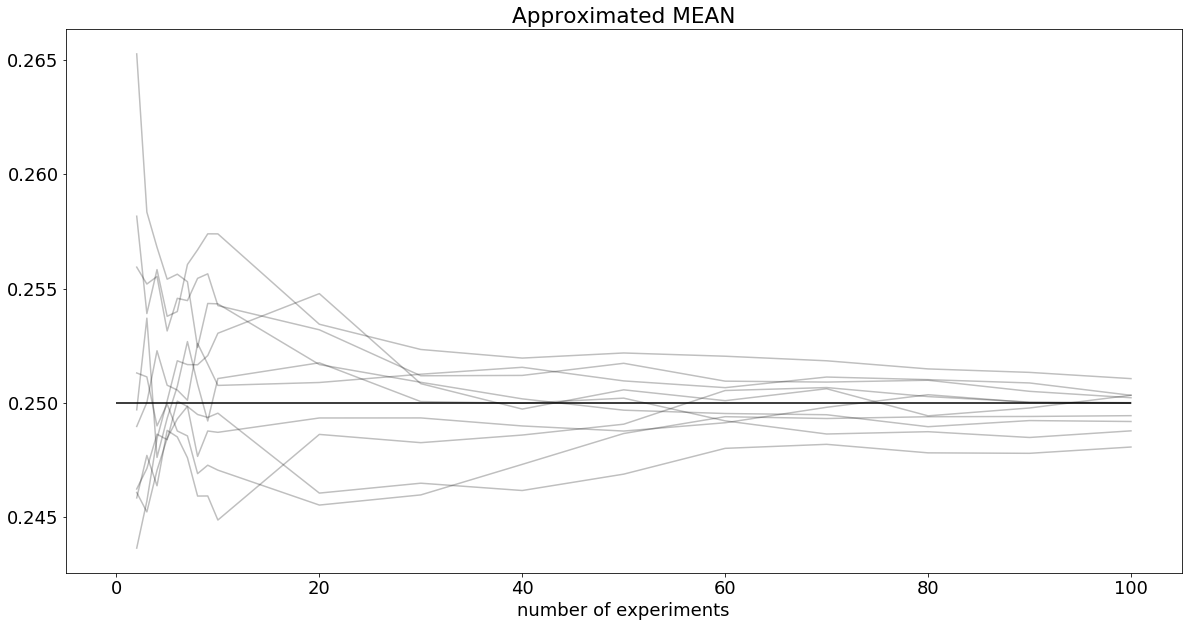

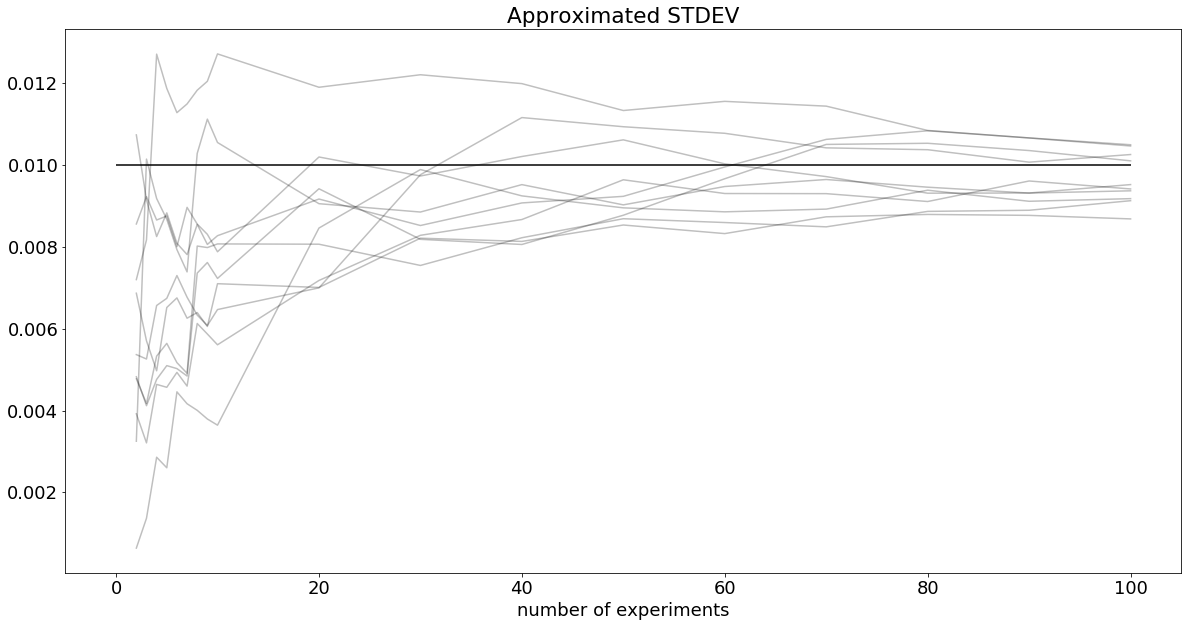

In [33]:
plt.figure(figsize=(20,10))
for s in range(len(seed)):
    A = T[d::5,:][s::10,:][i::8,:]
    plt.plot(A[:,1], np.array(DATA['obs_data_mean'])[d::5][s::10][i::8], c='k', alpha=0.25)
plt.hlines(lam_true, 0,100)
plt.title('Approximated MEAN')
plt.xlabel('number of experiments')
plt.show()

plt.figure(figsize=(20,10))
for s in range(len(seed)):
    A = T[d::5,:][s::10,:][i::8,:]
    ds = A[-1,-1]
    plt.plot(A[:,1], np.array(DATA['obs_data_std'])[d::5][s::10][i::8], c='k', alpha=0.25)
plt.hlines(ds, 0,100)
plt.title('Approximated STDEV')
plt.xlabel('number of experiments')
plt.show()

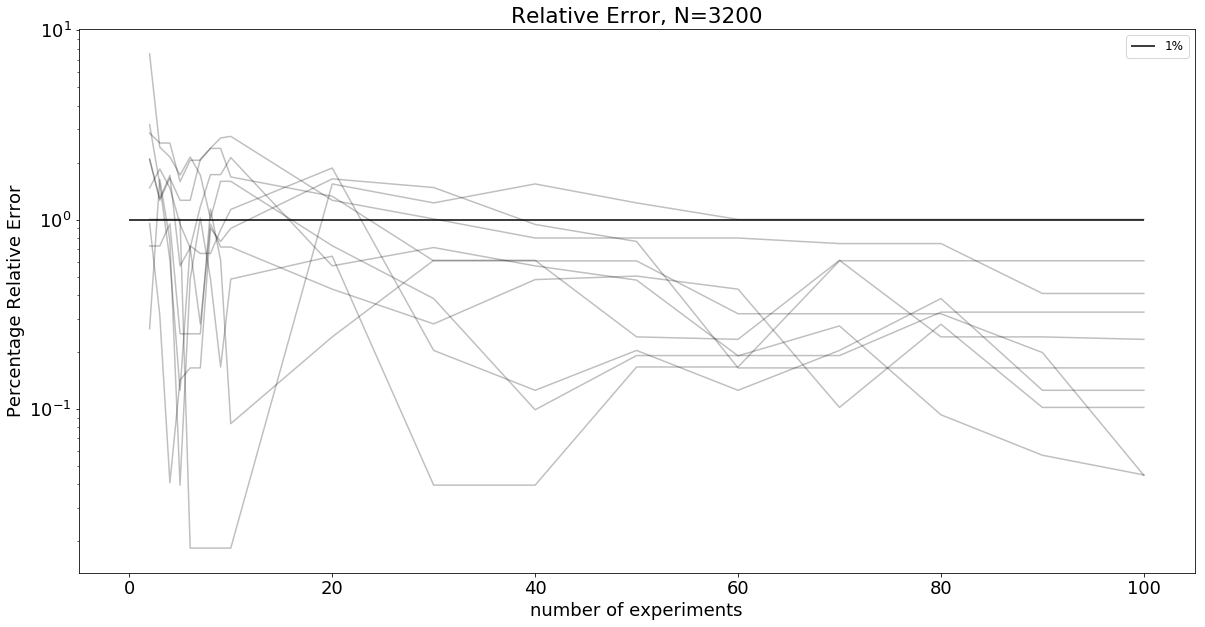

In [34]:
plt.figure(figsize=(20,10))
for s in range(len(seed)):
    A = T[d::5,:][s::10,:][i::8,:]
    nn = A[0,0]
    plt.semilogy(A[:,1], 100*np.array(DATA['rel_error_mc'])[d::5][s::10][i::8], c='k', alpha=0.25)
plt.title('Relative Error, N=%d'%nn)
# plt.ylim([1E-5, 1E-2])
plt.xlabel('number of experiments')
plt.ylabel('Percentage Relative Error')
plt.hlines(1,0,100, label='1%')
plt.legend(fontsize=12)
plt.show()

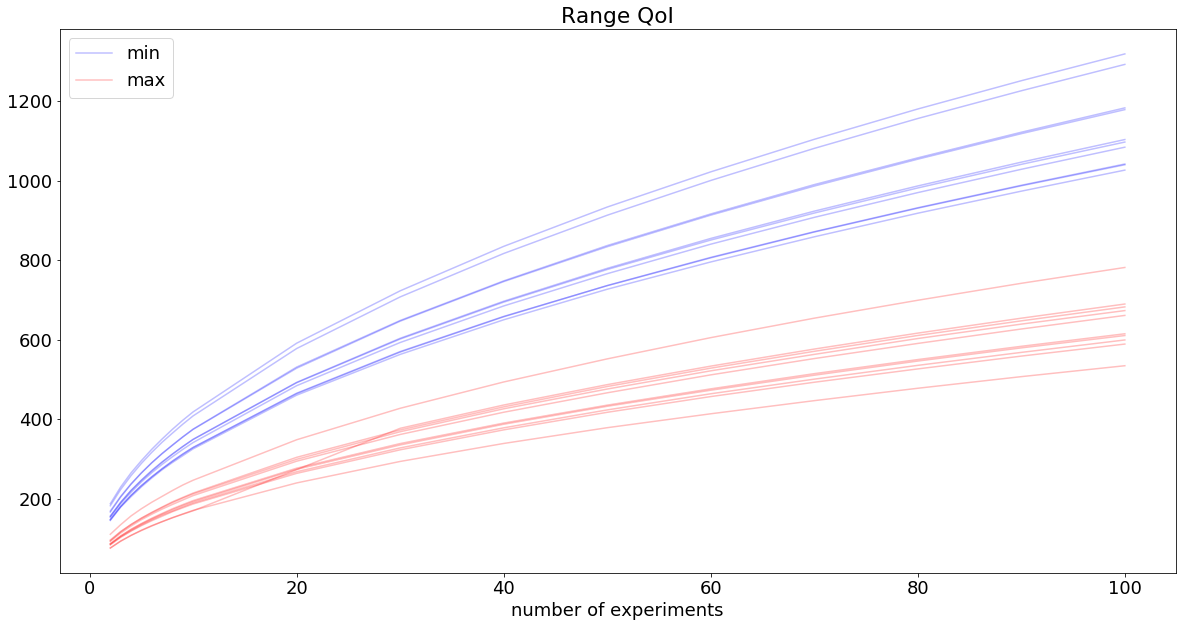

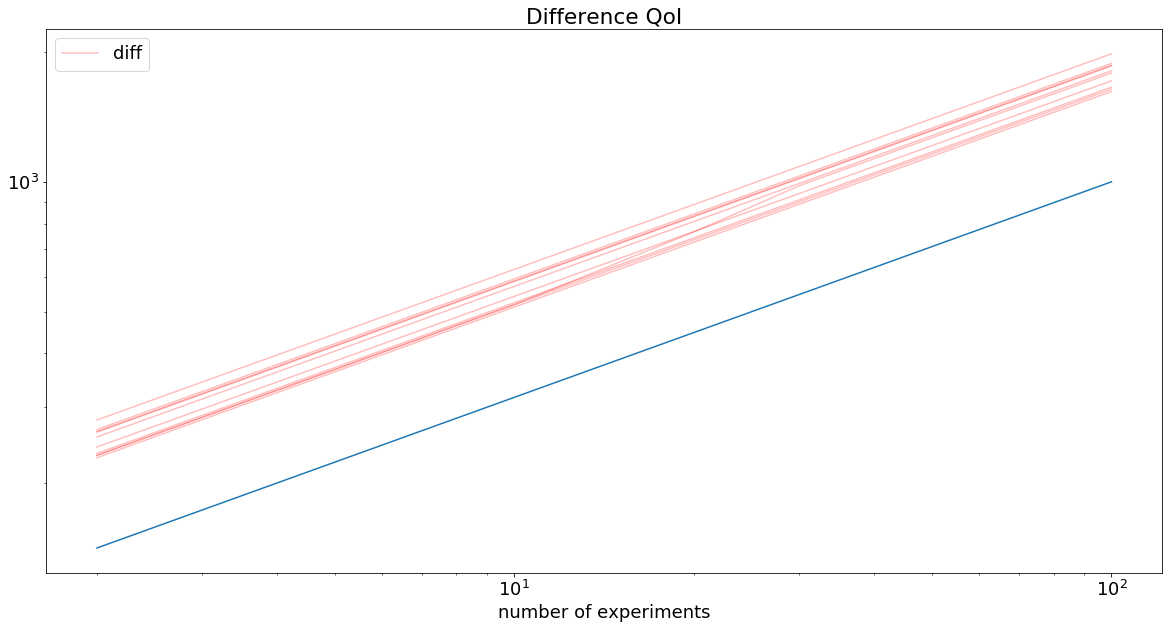

In [35]:
plt.figure(figsize=(20,10))
for s in range(len(seed)):
    A = T[d::5,:][s::10,:][i::8,:]
    if s<9:
        plt.plot(A[:,1], np.abs(np.array(DATA['mse_min'])[d::5][s::10][i::8]), c='b', alpha=0.25)
        plt.plot(A[:,1], np.array(DATA['mse_max'])[d::5][s::10][i::8], c='r', alpha=0.25)
    else:
        plt.plot(A[:,1], np.abs(np.array(DATA['mse_min'])[d::5][s::10][i::8]), c='b', alpha=0.25, label='min')
        plt.plot(A[:,1], np.array(DATA['mse_max'])[d::5][s::10][i::8], c='r', alpha=0.25, label='max')   
plt.title('Range QoI')
plt.legend()
plt.xlabel('number of experiments')
plt.show()

plt.figure(figsize=(20,10))
for s in range(len(seed)):
    A = T[d::5,:][s::10,:][i::8,:]
    if s<9:
        plt.loglog(A[:,1], np.abs(np.array(DATA['mse_min']) - np.array(DATA['mse_max']))[d::5][s::10][i::8], c='r', alpha=0.25)
    else:
        plt.loglog(A[:,1], np.abs(np.array(DATA['mse_min']) - np.array(DATA['mse_max']))[d::5][s::10][i::8], c='r', alpha=0.25, label='diff')   
plt.loglog(A[:,1], np.sqrt(10000*np.array(A[:,1])))
plt.title('Difference QoI')
plt.legend()
plt.xlabel('number of experiments')
plt.show()

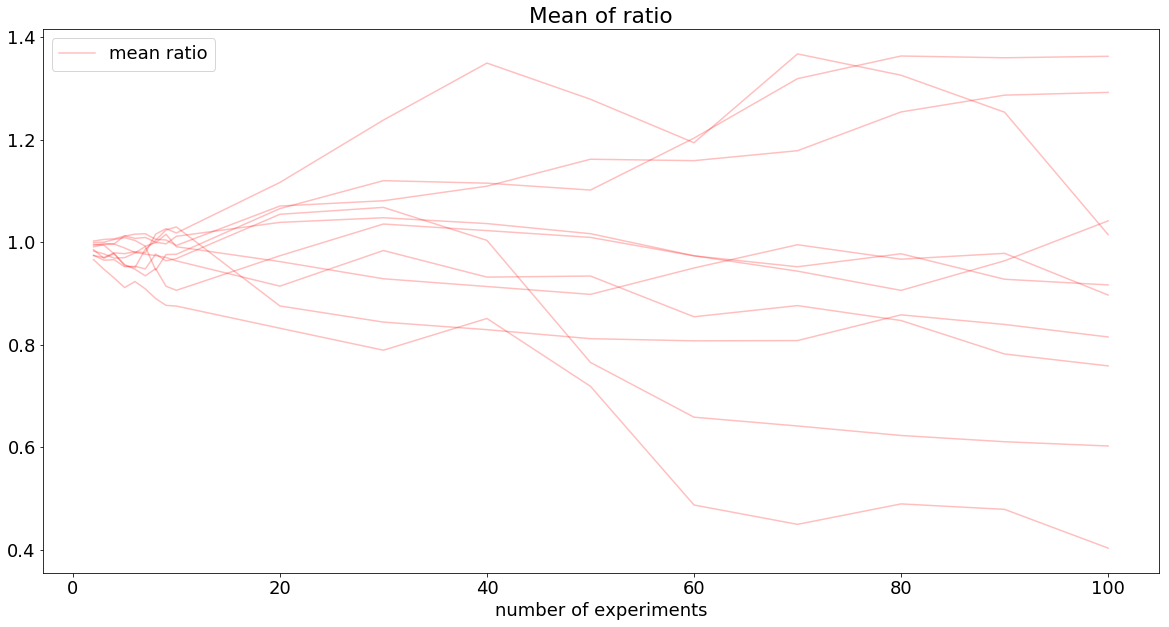

In [36]:
plt.figure(figsize=(20,10))
for s in range(len(seed)):
    A = T[d::5,:][s::10,:][i::8,:]
    if s<9:
        plt.plot(A[:,1], np.array(DATA['mean_r'])[d::5][s::10][i::8] , c='r', alpha=0.25)
    else:
        plt.plot(A[:,1], np.array(DATA['mean_r'])[d::5][s::10][i::8] , c='r', alpha=0.25, label='mean ratio')   
plt.title('Mean of ratio')
plt.legend()
plt.xlabel('number of experiments')
plt.show()

## Dependence on N

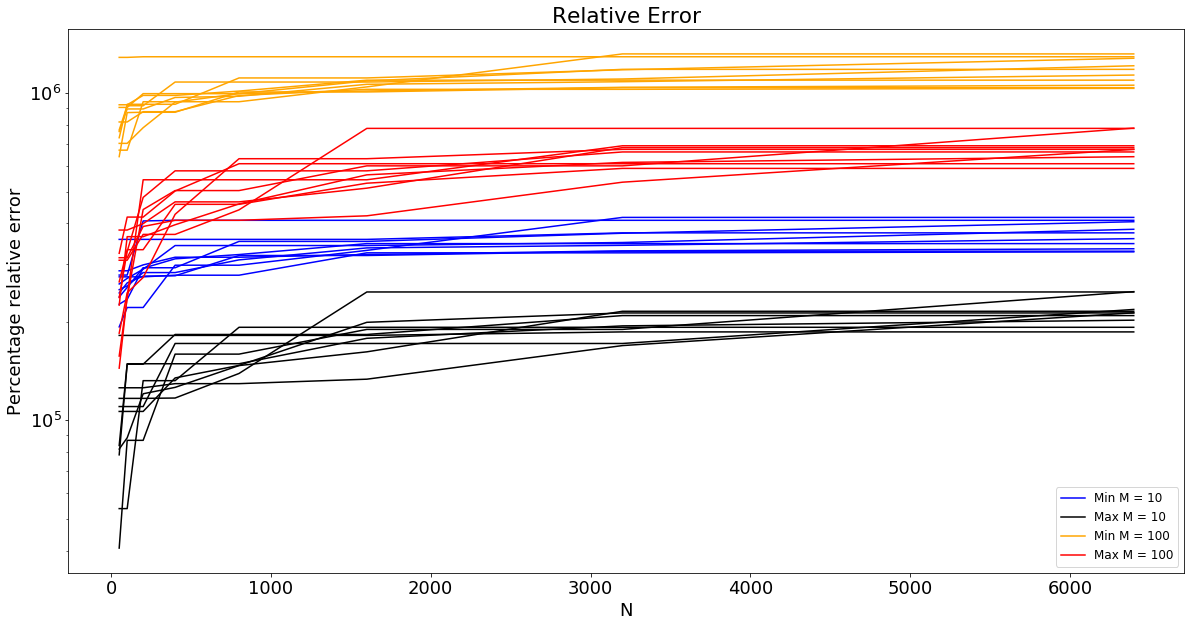

In [37]:
#loop through N
plt.figure(figsize=(20,10))
s = 1 # fix a seed < 10
d = 0 # fix assumed error choice = 2 => std = 0.01
M_vals = [10, 100]
M_inds = np.where(np.isin(M,M_vals))[0]
colors = ['blue', 'orange', 'black', 'red', 'black', 'magenta']
for k in range(len(M_inds)): # 12 => M=50
    for s in range(len(seed)):
        j=M_inds[k]*8
        A = T[d::5,:][s::10,:][j:(8+j),:]
        mm = T[d::5,:][s::10,:][j:(8+j),:][0,1] # M value
        if s < 1:
            plt.semilogy(A[:,0], 100*np.abs(np.array(DATA['mse_min']))[d::5][s::10][j:(8+j)], c=colors[k], alpha=1, label = 'Min M = %d'%mm)
            plt.semilogy(A[:,0], 100*np.array(DATA['mse_max'])[d::5][s::10][j:(8+j)], c=colors[k+2], alpha=1, label = 'Max M = %d'%mm)

        else:
            plt.semilogy(A[:,0], 100*np.abs(np.array(DATA['mse_min']))[d::5][s::10][j:(8+j)], c=colors[k], alpha=1)
            plt.semilogy(A[:,0], 100*np.array(DATA['mse_max'])[d::5][s::10][j:(8+j)], c=colors[k+2], alpha=1)
plt.title('Relative Error')
plt.xlabel('N')
plt.ylabel('Percentage relative error')
# plt.hlines(1,0,6400, label='1%',lw=2)
plt.legend(fontsize=12)
plt.show()

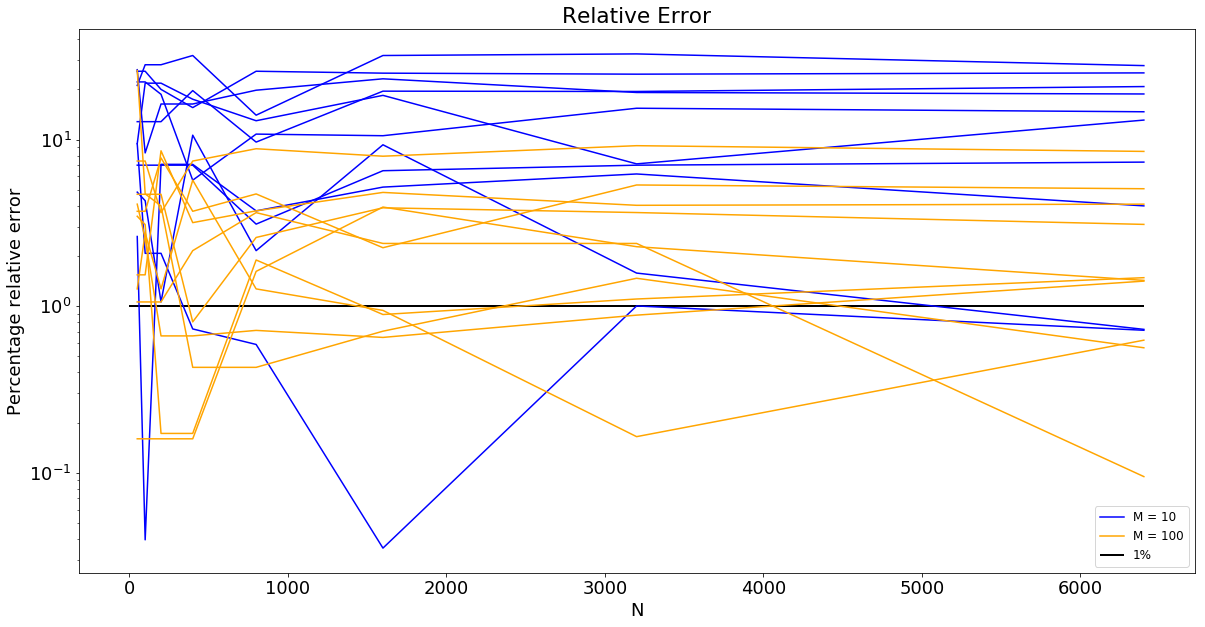

In [38]:
#loop through N
plt.figure(figsize=(20,10))
s = 1 # fix a seed < 10
d = 4 # fix assumed error choice = 2 => std = 0.01
M_vals = [10, 100]
M_inds = np.where(np.isin(M,M_vals))[0]
colors = ['blue', 'orange', 'black', 'red']
for k in range(len(M_inds)): # 12 => M=50
    for s in range(10):
        j=M_inds[k]*8
        A = T[d::5,:][s::10,:][j:(8+j),:]
        mm = T[d::5,:][s::10,:][j:(8+j),:][0,1] # M value
        if s < 1:
            plt.semilogy(A[:,0], 100*np.array(DATA['rel_error_mc'])[d::5][s::10][j:(8+j)], c=colors[k], alpha=1, label = 'M = %d'%mm)
        else:
            plt.semilogy(A[:,0], 100*np.array(DATA['rel_error_mc'])[d::5][s::10][j:(8+j)], c=colors[k], alpha=1)
plt.title('Relative Error')
plt.xlabel('N')
plt.ylabel('Percentage relative error')
plt.hlines(1,0,6400, label='1%',lw=2)
plt.legend(fontsize=12)
plt.show()

## More precise data = less stable mean ratio value
`data_std = 0.001` yields stable means for `N>3200`
`data_std = 0.0316` is good for `N>1000`
`data_st = 0.01` is good for `N>1000`

I think choosing `data_std = 0.01` and `N = 5000` should provide a good mix of speed/accuracy

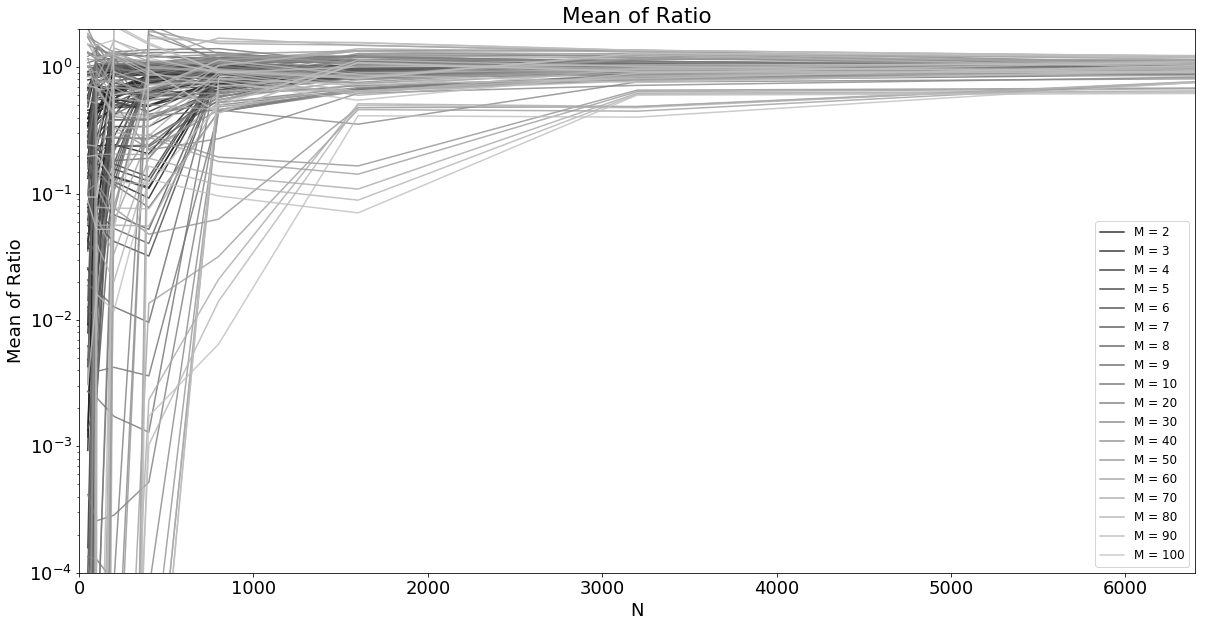

data_std =  0.01


In [39]:
#loop through N
plt.figure(figsize=(20,10))
s = 1 # fix a seed < 10
d = 2 # fix assumed error choice = 2 => std = 0.01
# M_vals = [10, 100]
M_vals =  [2,3,4,5,6,7,8,9, *np.arange(1,11)*10 ]
M_inds = np.where(np.isin(M,M_vals))[0]
# colors = ['blue', 'orange', 'black', 'red']
colors = np.linspace(0,0.75, len(M_vals))
for k in range(len(M_vals)): # 12 => M=50
    for s in range(len(seed)):
        j=M_inds[k]*8
        A = T[d::5,:][s::10,:][j:(8+j),:]
        mm = T[d::5,:][s::10,:][j:(8+j),:][0,1] # M value
        if s < 1:
            plt.semilogy(A[:,0], np.array(DATA['mean_r'])[d::5][s::10][j:(8+j)], c=colors[k]*np.ones(3), alpha=0.8, label = 'M = %d'%mm)
        else:
            plt.semilogy(A[:,0], np.array(DATA['mean_r'])[d::5][s::10][j:(8+j)], c=colors[k]*np.ones(3), alpha=0.8)
plt.title('Mean of Ratio')
plt.xlabel('N')
plt.ylabel('Mean of Ratio')
plt.ylim([1E-4, 2])
plt.xlim([0,6400])
plt.legend(fontsize=12)
plt.show()
print('data_std = ', data_std[d])

## Vary M (new runs)

In [40]:
N_ = 3000
data_std_ = 0.01
# M_list = [2,3,4,5,6,7,8,9, *np.arange(1,21)*5 ]
M_list = [5, 10, 25, 50, 100, 200]
num_seeds = 10
lam_true = 0.25
prior_mean = 0
prior_std = 0.25

seed_list = np.random.randint(2,10000,num_seeds) 
assert len(np.unique(seed)) == len(seed) # ensure no repetitions

# ax = plt.subplot(1,1,1)
DDD = {}
for seed_ in progressbar.progressbar(seed_list):
    DD = init_data_vec()
    for M_ in M_list:
        SMRY = solve_problem(N=N_, M=M_, seed=seed_, data_std=data_std_, lam_true=lam_true, prior_mean=prior_mean, prior_std=prior_std, plot=False)
        append_summary(SMRY, DD)
#     print(, DD['rel_error_mc'])
    DDD[str(seed_)] = DD
print('Done running.')

N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

input sample shape: (1, 3000)
output sample shape: (5, 3000)
Loss fun min: -68.64973445202223 MSE max: 37.994159702650485


AttributeError: 'tuple' object has no attribute 'keys'

In [ ]:
plt.figure(figsize=(20,10))
for seed_ in seed_list:
    plt.semilogy(DDD[str(seed_)]['M'], DDD[str(seed_)]['mean_r'], color='k', alpha=0.5)
plt.ylim([1E-1, 2])
plt.show()

## Vary N (new runs)